In [16]:
%pip install matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.10.8-cp314-cp314-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp314-cp314-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp314-cp314-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp314-cp314-win_amd64.whl.metadata (6.4 kB)
   ---------------------------------------- 0.0/8.3 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.3 MB 3.5 MB/s eta 0:00:03
   ------- -------------------------------- 1.6/8.3 MB 4.6 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.3 MB 5.4 MB/s eta 0:00:01
   --------------------- ------------------ 4.5/8.3 MB 5.6 MB/s eta 0:00:01
   ------------------------- -------------- 5.2/8.3 MB 5.6 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.3 MB 5.8 MB/s eta 0:00:01
   ---------------------------


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv("..\STEP1_PRETREATMENT\DISASTERS.csv")

In [19]:
print(df.head())

   Year   Seq Glide Disaster Group Disaster Subgroup      Disaster Type  \
0  1900  9002   NaN        Natural    Climatological            Drought   
1  1900  9001   NaN        Natural    Climatological            Drought   
2  1902    12   NaN        Natural       Geophysical         Earthquake   
3  1902     3   NaN        Natural       Geophysical  Volcanic activity   
4  1902    10   NaN        Natural       Geophysical  Volcanic activity   

  Disaster Subtype Disaster Subsubtype   Event Name     Country  ISO  \
0          Drought                 NaN          NaN  Cabo Verde  CPV   
1          Drought                 NaN          NaN       India  IND   
2  Ground movement                 NaN          NaN   Guatemala  GTM   
3         Ash fall                 NaN  Santa Maria   Guatemala  GTM   
4         Ash fall                 NaN  Santa Maria   Guatemala  GTM   

            Region Continent                   Location Origin  \
0   Western Africa    Africa                Countr

In [20]:
# Supression des colonnes inutiles car elles ne vont pas nous servire dans notre etude
print("\n Suppression des colonnes administratives...")

# Colonnes à supprimer (peu utiles pour ML)
columns_to_drop = ['Seq', 'Glide', 'OFDA Response', 'Appeal', 'Declaration','Disaster Subsubtype'
                   'Aid Contribution', 'Associated Dis', 'Associated Dis2',
                   'Event Name', 'Origin', 'Local Time', 'River Basin',
                   'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations']

df_clean = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
print(f" Colonnes supprimées: {[col for col in columns_to_drop if col in df.columns]}")


 Suppression des colonnes administratives...
 Colonnes supprimées: ['Seq', 'Glide', 'OFDA Response', 'Appeal', 'Declaration', 'Associated Dis', 'Associated Dis2', 'Event Name', 'Origin', 'Local Time', 'River Basin', 'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations']


In [21]:
# selection des colonnes importantes
print("\n Sélection des colonnes pertinentes...")

columns_to_keep = [
    'Year', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type',
    'Disaster Subtype', 'Country', 'ISO', 'Region', 'Continent',
    'Location', 'Latitude', 'Longitude',
    'Start Year', 'Start Month', 'Start Day',
    'End Year', 'End Month', 'End Day',
    'Dis Mag Value', 'Dis Mag Scale',
    'Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
    'Total Affected', 'Total Damages (\'000 US$)', 'Insured Damages (\'000 US$)'
]

columns_to_keep = [col for col in columns_to_keep if col in df_clean.columns]
df_clean = df_clean[columns_to_keep].copy()

print(f"{len(columns_to_keep)} colonnes sélectionnées")


 Sélection des colonnes pertinentes...
27 colonnes sélectionnées


In [22]:
# nettoyage des valeurs manquantes

print("\n Nettoyage des valeurs manquantes...")

# Supprimer les lignes avec trop de valeurs manquantes (>50%)
df_clean = df_clean.dropna(thresh=len(df_clean.columns) * 0.5)

# Remplir les valeurs manquantes pour les colonnes d'impact par 0
impact_cols = ['Total Deaths', 'No Injured', 'No Affected', 'No Homeless',
               'Total Affected', 'Total Damages (\'000 US$)', 'Insured Damages (\'000 US$)']

for col in impact_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(0).clip(lower=0)

# Coordonnées: Nettoyer et convertir en numérique, puis remplir par la médiane du pays
if 'Latitude' in df_clean.columns:
    # Remove non-numeric characters and convert to float
    df_clean['Latitude'] = df_clean['Latitude'].astype(str).str.replace(r'[^\d.-]', '', regex=True)
    df_clean['Latitude'] = pd.to_numeric(df_clean['Latitude'], errors='coerce')
    df_clean['Latitude'] = df_clean.groupby('Country')['Latitude'].transform(
        lambda x: x.fillna(x.median() if not x.isnull().all() else np.nan)
    )
if 'Longitude' in df_clean.columns:
    # Remove non-numeric characters and convert to float
    df_clean['Longitude'] = df_clean['Longitude'].astype(str).str.replace(r'[^\d.-]', '', regex=True)
    df_clean['Longitude'] = pd.to_numeric(df_clean['Longitude'], errors='coerce')
    df_clean['Longitude'] = df_clean.groupby('Country')['Longitude'].transform(
        lambda x: x.fillna(x.median() if not x.isnull().all() else np.nan)
    )

print(f" Lignes restantes: {len(df_clean)}")


 Nettoyage des valeurs manquantes...
 Lignes restantes: 15894


In [23]:
# création des dates et durée
print("\n Création des colonnes de dates...")

def create_date(row, date_type='start'):
    try:
        if date_type == 'start':
            year = row['Start Year']
            month = row['Start Month'] if pd.notna(row['Start Month']) else 1
            day = row['Start Day'] if pd.notna(row['Start Day']) else 1
        else:
            year = row['End Year']
            month = row['End Month'] if pd.notna(row['End Month']) else 12
            day = row['End Day'] if pd.notna(row['End Day']) else 31
        return pd.to_datetime(f"{int(year)}-{int(month)}-{int(day)}", errors='coerce')
    except:
        return pd.NaT

df_clean['Start_Date'] = df_clean.apply(lambda row: create_date(row, 'start'), axis=1)
df_clean['End_Date'] = df_clean.apply(lambda row: create_date(row, 'end'), axis=1)

# Durée en jours
df_clean['Duration_Days'] = (df_clean['End_Date'] - df_clean['Start_Date']).dt.days
df_clean['Duration_Days'] = df_clean['Duration_Days'].fillna(1).clip(lower=0)

print(" Dates et durée créées")


 Création des colonnes de dates...
 Dates et durée créées


In [24]:
#Création des features temporelles
print("\n Création des features temporelles...")

df_clean['Month'] = df_clean['Start_Date'].dt.month
df_clean['Season'] = df_clean['Month'].apply(lambda x:
    'Winter' if x in [12, 1, 2] else
    'Spring' if x in [3, 4, 5] else
    'Summer' if x in [6, 7, 8] else
    'Fall' if pd.notna(x) and x in [9, 10, 11] else 'Unknown'
)

print(" Features temporelles créées")


 Création des features temporelles...
 Features temporelles créées


In [25]:
# Score de severite
print("\n Calcul du score de sévérité...")

def normalize(series):
    min_val = series.min()
    max_val = series.max()
    if max_val - min_val == 0:
        return pd.Series([0] * len(series))
    return (series - min_val) / (max_val - min_val)

deaths_norm = normalize(df_clean['Total Deaths'])
affected_norm = normalize(df_clean['Total Affected'])

if 'Total Damages (\'000 US$)' in df_clean.columns:
    damages_norm = normalize(df_clean['Total Damages (\'000 US$)'])
    df_clean['Severity_Score'] = (deaths_norm * 0.5 + affected_norm * 0.3 + damages_norm * 0.2)
else:
    df_clean['Severity_Score'] = (deaths_norm * 0.6 + affected_norm * 0.4)

# Catégories de sévérité
df_clean['Severity_Category'] = pd.cut(
    df_clean['Severity_Score'],
    bins=[0, 0.25, 0.50, 0.75, 1.0],
    labels=['Low', 'Medium', 'High', 'Extreme'],
    include_lowest=True
)

print(" Score et catégories de sévérité créés")


 Calcul du score de sévérité...
 Score et catégories de sévérité créés


In [26]:
# Création des bins pour la magnitude
print("\n Création des bins pour la magnitude...")

if 'Dis Mag Value' in df_clean.columns:
    # Remplacer les valeurs manquantes par la médiane
    df_clean['Dis Mag Value'] = df_clean['Dis Mag Value'].fillna(df_clean['Dis Mag Value'].median())

    # Créer des catégories basées sur les quartiles
    df_clean['Magnitude_Category'] = pd.cut(
        df_clean['Dis Mag Value'],
        bins=[0, 2, 4, 6, 8, float('inf')],
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'],
        include_lowest=True
    )

    print(f" Bins de magnitude créés")
    print(f"   Distribution: {df_clean['Magnitude_Category'].value_counts().to_dict()}")
else:
    print(" Colonne 'Dis Mag Value' non trouvée")


 Création des bins pour la magnitude...
 Bins de magnitude créés
   Distribution: {'Very High': 14292, 'Medium': 785, 'High': 639, 'Low': 36, 'Very Low': 10}


In [27]:
print("\n Encodage manuel des variables catégorielles...")

categorical_cols = [
    'Disaster Group', 'Disaster Subgroup', 'Disaster Type',
    'Disaster Subtype', 'Country', 'Region', 'Continent',
    'Season', 'Magnitude_Category'
]

# Dictionnaire qui va stocker les légendes de toutes les colonnes
legendes = {}

for col in categorical_cols:
    if col in df_clean.columns:

        #  créer une liste des valeurs uniques
        valeurs_uniques = df_clean[col].astype(str).unique()

        #  créer le dictionnaire {valeur : numéro}
        mapping = {val: i for i, val in enumerate(valeurs_uniques)}

        #  enregistrer la légende
        legendes[col] = mapping

        #  remplacer dans le dataframe
        df_clean[col] = df_clean[col].astype(str).map(mapping)

print("Encodage terminé.\n")

#  Affichage de la légende
for col, mapping in legendes.items():
    print(f"\nLégende pour {col}:")
    for val, code in mapping.items():
        print(f"  {code} → {val}")



 Encodage manuel des variables catégorielles...
Encodage terminé.


Légende pour Disaster Group:
  0 → Natural

Légende pour Disaster Subgroup:
  0 → Climatological
  1 → Geophysical
  2 → Meteorological
  3 → Hydrological
  4 → Biological
  5 → Extra-terrestrial

Légende pour Disaster Type:
  0 → Drought
  1 → Earthquake
  2 → Volcanic activity
  3 → Mass movement (dry)
  4 → Storm
  5 → Flood
  6 → Landslide
  7 → Epidemic
  8 → Wildfire
  9 → Extreme temperature 
  10 → Fog
  11 → Insect infestation
  12 → Impact
  13 → Animal accident
  14 → Glacial lake outburst

Légende pour Disaster Subtype:
  0 → Drought
  1 → Ground movement
  2 → Ash fall
  3 → Rockfall
  4 → Tropical cyclone
  5 → nan
  6 → Landslide
  7 → Avalanche
  8 → Bacterial disease
  9 → Forest fire
  10 → Convective storm
  11 → Riverine flood
  12 → Viral disease
  13 → Mudslide
  14 → Tsunami
  15 → Heat wave
  16 → Land fire (Brush, Bush, Pasture)
  17 → Coastal flood
  18 → Cold wave
  19 → Flash flood
  20 → P

In [28]:
# Supprimer les colonnes de dates individuelles (on garde Start_Date, End_Date)
cols_to_drop = ['Start Year', 'Start Month', 'Start Day',
                'End Year', 'End Month', 'End Day']
df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])

In [29]:
# Sauvegarde du fichier nettoyé
print("\n Sauvegarde du fichier nettoyé...")

output_filename = 'DISASTERS_CLEANED.csv'
df_clean.to_csv(output_filename, index=False)

print(f" Fichier sauvegardé: {output_filename}")


 Sauvegarde du fichier nettoyé...
 Fichier sauvegardé: DISASTERS_CLEANED.csv


In [30]:
# Rapport final
print("\n" + "="*60)
print(" RAPPORT DE PRÉTRAITEMENT")
print("="*60)

print(f"\n Dataset original: {df.shape[0]} lignes, {df.shape[1]} colonnes")
print(f" Dataset nettoyé: {df_clean.shape[0]} lignes, {df_clean.shape[1]} colonnes")
print(f" Lignes supprimées: {df.shape[0] - df_clean.shape[0]}")

print("\n Nouvelles colonnes créées:")
new_cols = ['Start_Date', 'End_Date', 'Duration_Days', 'Month', 'Season',
            'Severity_Score', 'Severity_Category', 'Magnitude_Category']
for col in new_cols:
    if col in df_clean.columns:
        print(f"  ✓ {col}")

print("\n Distribution des catégories de sévérité:")
print(df_clean['Severity_Category'].value_counts())

print("\n Top 5 pays les plus touchés:")
print(df_clean['Country'].value_counts().head(5))

print("\n Types de catastrophes:")
print(df_clean['Disaster Type'].value_counts().head(5))


print("PRÉTRAITEMENT TERMINÉ AVEC SUCCÈS!")




 RAPPORT DE PRÉTRAITEMENT

 Dataset original: 16126 lignes, 45 colonnes
 Dataset nettoyé: 15894 lignes, 29 colonnes
 Lignes supprimées: 232

 Nouvelles colonnes créées:
  ✓ Start_Date
  ✓ End_Date
  ✓ Duration_Days
  ✓ Month
  ✓ Season
  ✓ Severity_Score
  ✓ Severity_Category
  ✓ Magnitude_Category

 Distribution des catégories de sévérité:
Severity_Category
Low        15887
Medium         6
High           1
Extreme        0
Name: count, dtype: int64

 Top 5 pays les plus touchés:
Country
67    1079
9      972
1      743
75     667
14     566
Name: count, dtype: int64

 Types de catastrophes:
Disaster Type
5    5513
4    4481
1    1544
7    1481
6     759
Name: count, dtype: int64
PRÉTRAITEMENT TERMINÉ AVEC SUCCÈS!


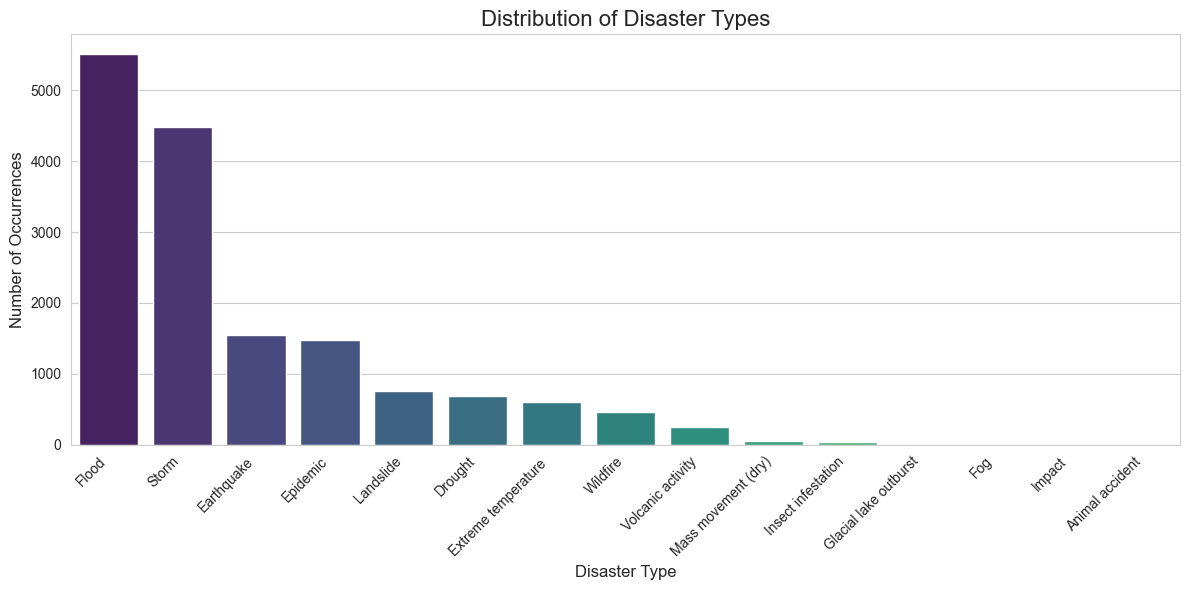

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts for 'Disaster Type'
disaster_type_counts = df_clean['Disaster Type'].value_counts()

# Get the legend for 'Disaster Type'
disaster_type_legend = legendes['Disaster Type']

# Create a reverse mapping for plotting original names
reverse_disaster_type_legend = {v: k for k, v in disaster_type_legend.items()}

# Map the encoded types back to their original names for better readability
plot_data = disaster_type_counts.rename(index=reverse_disaster_type_legend)

# Set plot style
sns.set_style('whitegrid')

# Create the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=plot_data.index, y=plot_data.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Disaster Types', fontsize=16)
plt.xlabel('Disaster Type', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


 ÉVOLUTION TEMPORELLE DU NOMBRE DE CATASTROPHES


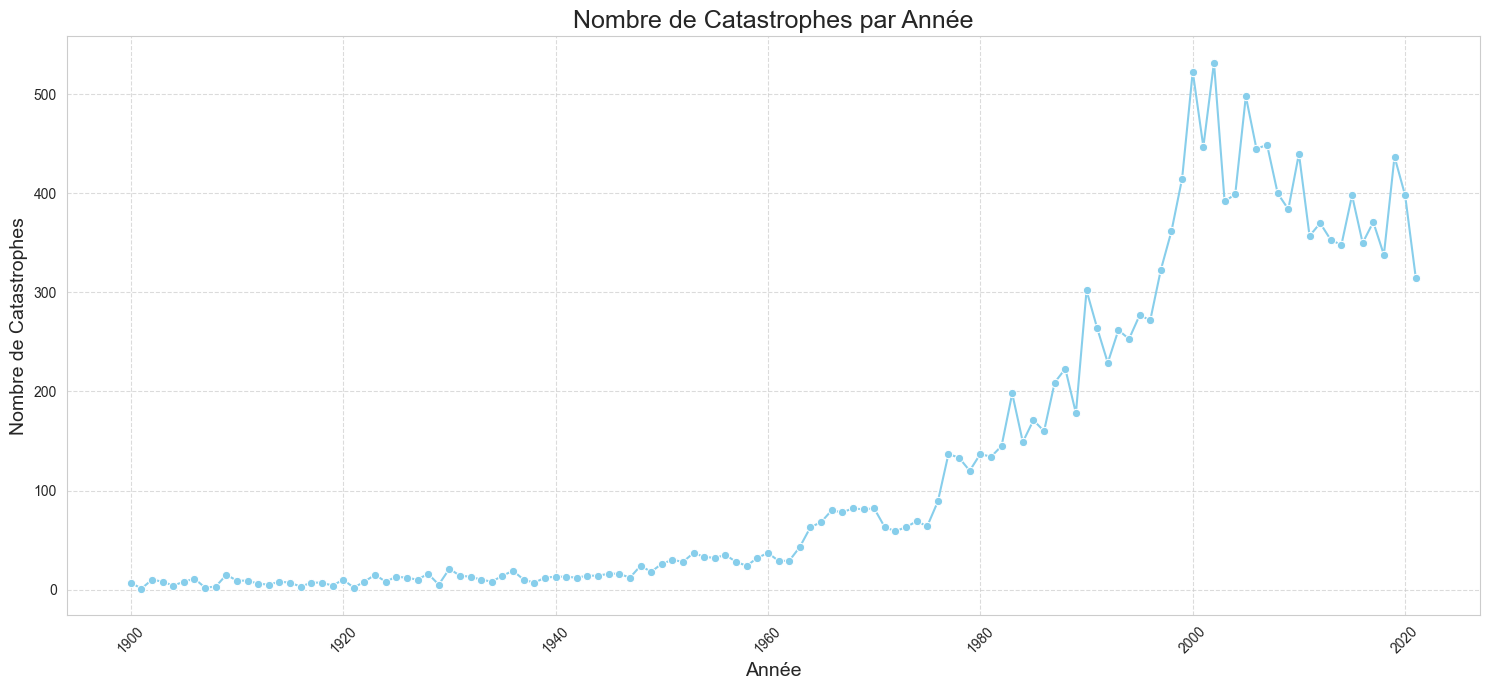

In [32]:
print("\n" + "="*60)
print(" ÉVOLUTION TEMPORELLE DU NOMBRE DE CATASTROPHES")
print("="*60)

# Calcul du nombre de catastrophes par année
disasters_by_year = df_clean['Year'].value_counts().sort_index()

# Création du graphique linéaire
plt.figure(figsize=(15, 7))
sns.lineplot(x=disasters_by_year.index, y=disasters_by_year.values, marker='o', color='skyblue')

# Ajout des titres et labels
plt.title('Nombre de Catastrophes par Année', fontsize=18)
plt.xlabel('Année', fontsize=14)
plt.ylabel('Nombre de Catastrophes', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


 TOP 10 PAYS LES PLUS TOUCHÉS


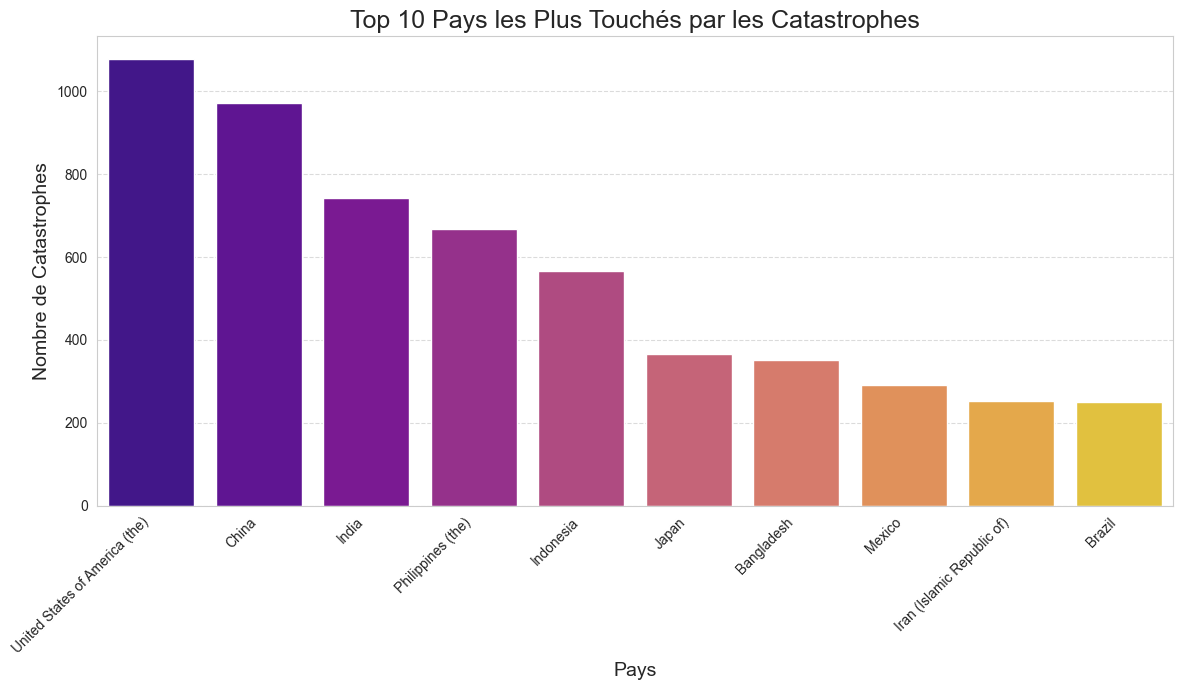

In [33]:
print("\n" + "="*60)
print(" TOP 10 PAYS LES PLUS TOUCHÉS")
print("="*60)

# Calcul du nombre de catastrophes par pays
disasters_by_country = df_clean['Country'].value_counts().head(10)

# Récupérer la légende pour les noms de pays
country_legend = legendes['Country']
reverse_country_legend = {v: k for k, v in country_legend.items()}

# Mapper les IDs de pays vers leurs noms originaux
plot_data_country = disasters_by_country.rename(index=reverse_country_legend)

# Création du graphique à barres
plt.figure(figsize=(12, 7))
sns.barplot(x=plot_data_country.index, y=plot_data_country.values, palette='plasma')

# Ajout des titres et labels
plt.title('Top 10 Pays les Plus Touchés par les Catastrophes', fontsize=18)
plt.xlabel('Pays', fontsize=14)
plt.ylabel('Nombre de Catastrophes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


 HEATMAP DES CATASTROPHES PAR RÉGION ET TYPE


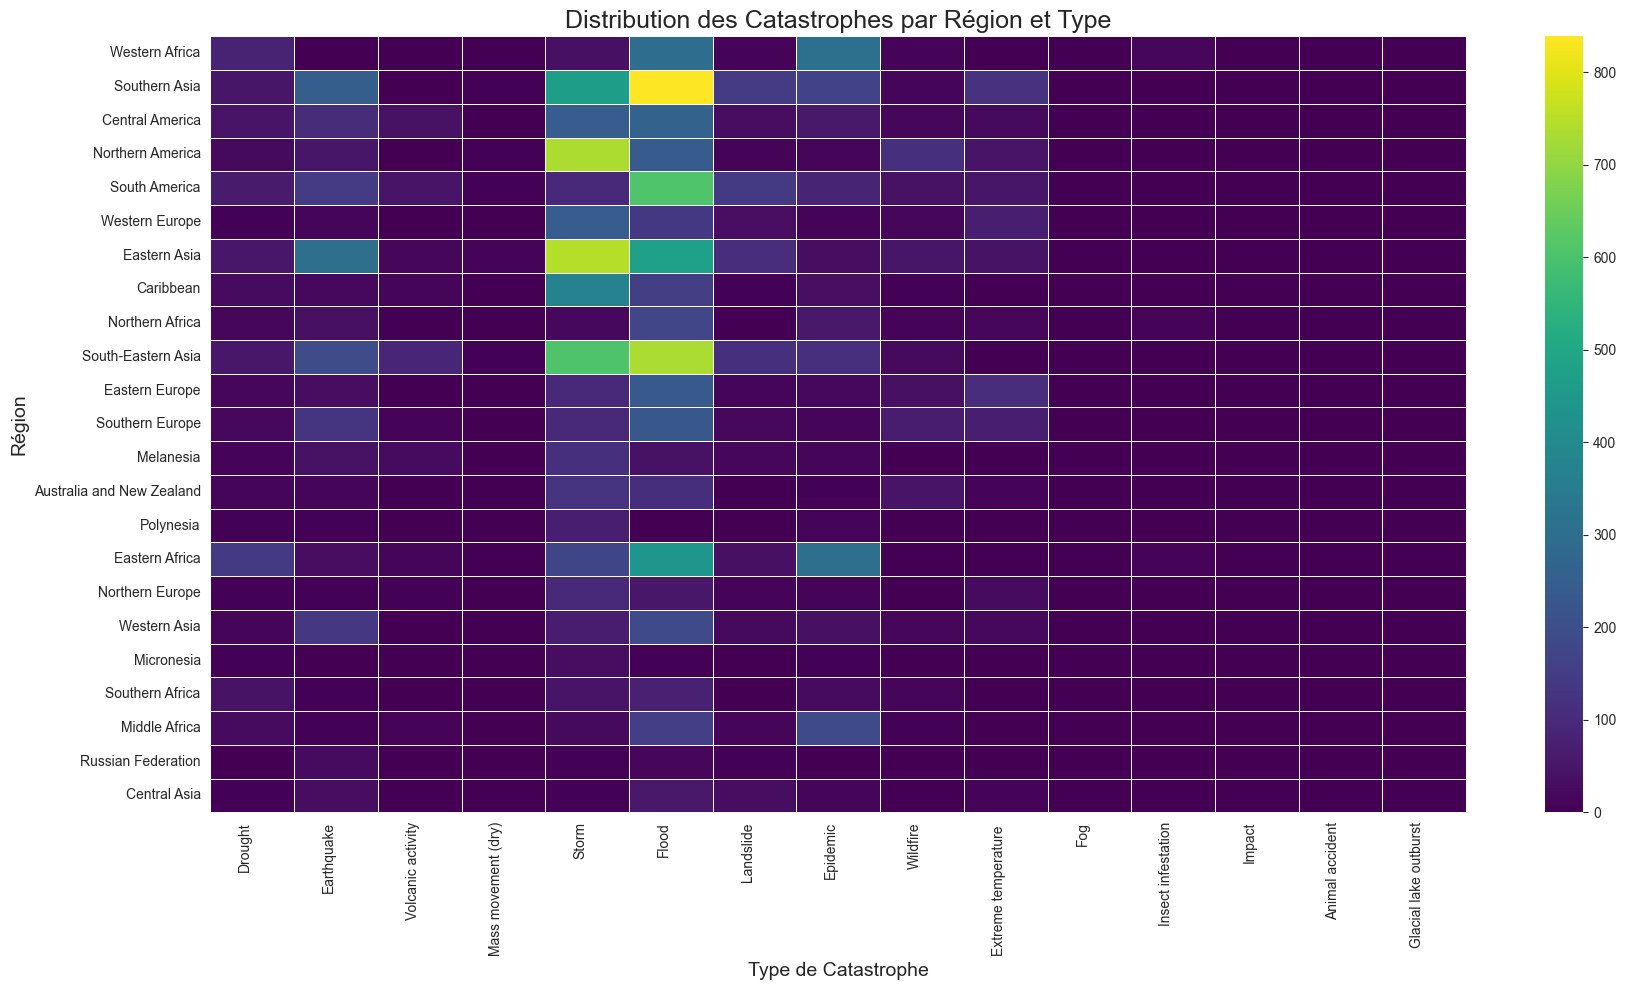

In [34]:
print("\n" + "="*60)
print(" HEATMAP DES CATASTROPHES PAR RÉGION ET TYPE")
print("="*60)

# Agréger les données par Région et Type de Catastrophe
heatmap_data = df_clean.groupby(['Region', 'Disaster Type']).size().unstack(fill_value=0)

# Récupérer les légendes pour les noms de régions et de types de catastrophes
region_legend = legendes['Region']
reverse_region_legend = {v: k for k, v in region_legend.items()}

disaster_type_legend = legendes['Disaster Type']
reverse_disaster_type_legend = {v: k for k, v in disaster_type_legend.items()}

# Mapper les IDs de régions et de types de catastrophes vers leurs noms originaux
heatmap_data.index = heatmap_data.index.map(reverse_region_legend)
heatmap_data.columns = heatmap_data.columns.map(reverse_disaster_type_legend)

# Création de la heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt='d', linewidths=.5)

# Ajout des titres et labels
plt.title('Distribution des Catastrophes par Région et Type', fontsize=18)
plt.xlabel('Type de Catastrophe', fontsize=14)
plt.ylabel('Région', fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
import folium

print("\n" + "="*60)
print(" CARTE GÉOGRAPHIQUE INTERACTIVE DES CATASTROPHES")
print("="*60)

# Créer une carte Folium centrée sur la moyenne des latitudes et longitudes
# Filtrer les NaN pour éviter les erreurs de centrage
valid_lat = df_clean['Latitude'].dropna()
valid_lon = df_clean['Longitude'].dropna()

if not valid_lat.empty and not valid_lon.empty:
    map_center = [valid_lat.mean(), valid_lon.mean()]
else:
    # Fallback si aucune coordonnée n'est disponible
    map_center = [0, 0]

disaster_map = folium.Map(location=map_center, zoom_start=2)

# Ajouter un marqueur pour chaque catastrophe
for idx, row in df_clean.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        # Récupérer les noms originaux des catégories pour le popup
        disaster_type_name = reverse_disaster_type_legend.get(row['Disaster Type'], 'Unknown')
        country_name = reverse_country_legend.get(row['Country'], 'Unknown')

        popup_html = f"""
            <b>Type de Catastrophe:</b> {disaster_type_name}<br>
            <b>Pays:</b> {country_name}<br>
            <b>Année:</b> {int(row['Year'])}<br>
            <b>Score de Sévérité:</b> {row['Severity_Score']:.2f}<br>
            <b>Catégorie de Sévérité:</b> {row['Severity_Category']}
        """
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=5, # Taille du cercle
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6,
            popup=folium.Popup(popup_html, max_width=300)
        ).add_to(disaster_map)

# Afficher la carte
display(disaster_map)

print(" Carte interactive générée avec succès.")

ModuleNotFoundError: No module named 'folium'


 CORRÉLATION ENTRE MAGNITUDE ET IMPACT

Matrice de Corrélation:
                          Dis Mag Value  Total Deaths  \
Dis Mag Value                  1.000000     -0.001358   
Total Deaths                  -0.001358      1.000000   
Total Damages ('000 US$)       0.007995      0.010038   

                          Total Damages ('000 US$)  
Dis Mag Value                             0.007995  
Total Deaths                              0.010038  
Total Damages ('000 US$)                  1.000000  


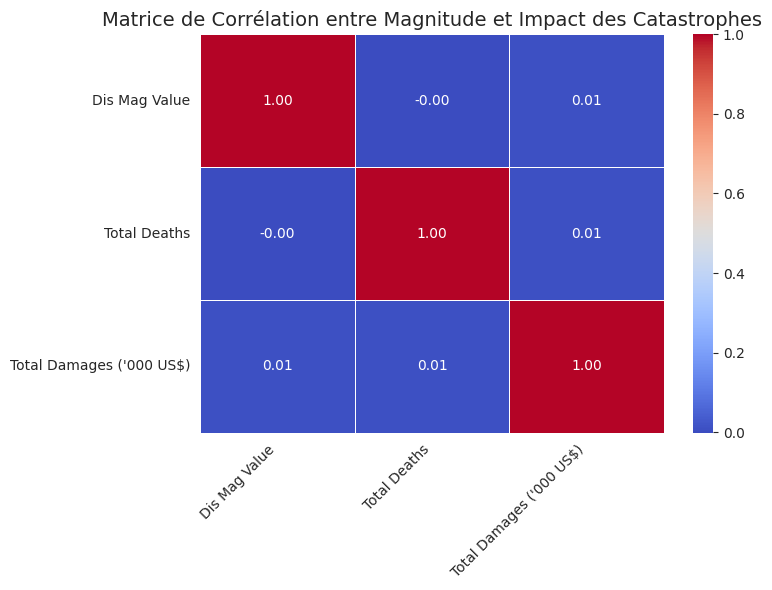


Analyse de la corrélation terminée.


In [ ]:
print("\n" + "="*60)
print(" CORRÉLATION ENTRE MAGNITUDE ET IMPACT")
print("="*60)

# Sélection des colonnes pertinentes pour la corrélation
correlation_cols = ['Dis Mag Value', 'Total Deaths', 'Total Damages (\'000 US$)']

# Filtrer le DataFrame pour inclure uniquement ces colonnes
# Assurer que les colonnes existent avant de les sélectionner
existing_correlation_cols = [col for col in correlation_cols if col in df_clean.columns]
df_correlation = df_clean[existing_correlation_cols]

# Calcul de la matrice de corrélation
correlation_matrix = df_correlation.corr()

print("\nMatrice de Corrélation:")
print(correlation_matrix)

# Visualisation de la matrice de corrélation avec une heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corrélation entre Magnitude et Impact des Catastrophes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nAnalyse de la corrélation terminée.")


 DISTRIBUTION DES DOMMAGES ÉCONOMIQUES


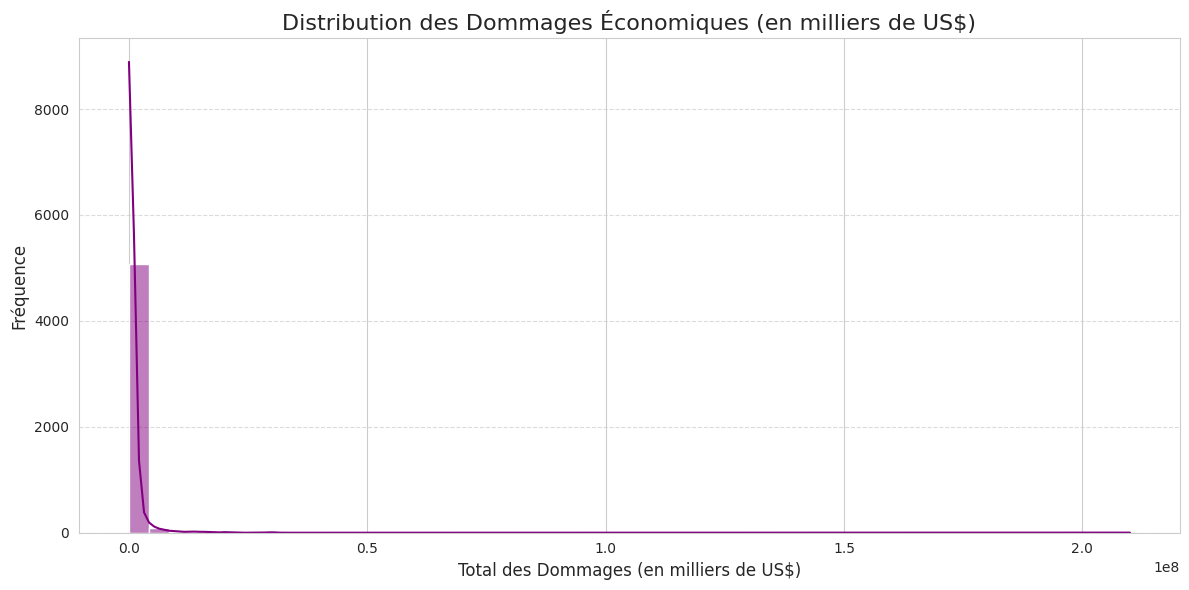


Analyse de la distribution des dommages terminée.


In [ ]:
print("\n" + "="*60)
print(" DISTRIBUTION DES DOMMAGES ÉCONOMIQUES")
print("="*60)

# Filtrer les valeurs de dommages non nulles pour une meilleure visualisation
damages_data = df_clean[df_clean["Total Damages ('000 US$)"] > 0]["Total Damages ('000 US$)"]

if not damages_data.empty:
    # Création de l'histogramme
    plt.figure(figsize=(12, 6))
    sns.histplot(damages_data, bins=50, kde=True, color='purple')

    # Ajout des titres et labels
    plt.title('Distribution des Dommages Économiques (en milliers de US$)', fontsize=16)
    plt.xlabel('Total des Dommages (en milliers de US$)', fontsize=12)
    plt.ylabel('Fréquence', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée de dommages économiques supérieure à 0 n'a été trouvée pour la visualisation.")

print("\nAnalyse de la distribution des dommages terminée.")


 ANALYSE SAISONNIÈRE : MOIS LES PLUS DANGEREUX


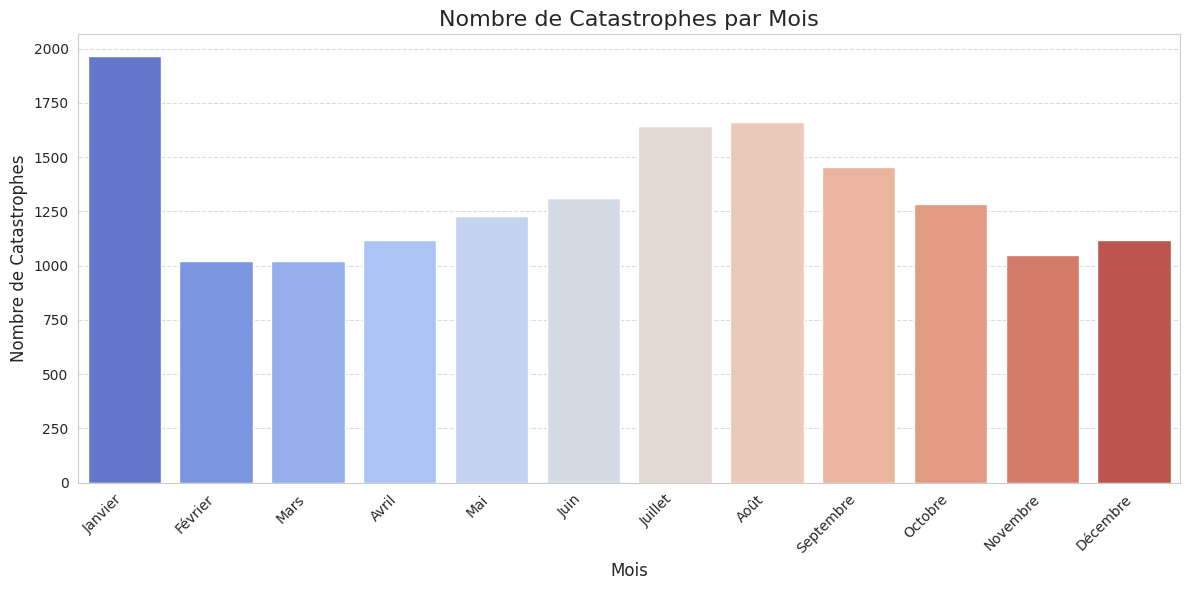


Analyse saisonnière terminée.


In [ ]:
print("\n" + "="*60)
print(" ANALYSE SAISONNIÈRE : MOIS LES PLUS DANGEREUX")
print("="*60)

# Calcul du nombre de catastrophes par mois
disasters_by_month = df_clean['Month'].value_counts().sort_index()

# Mapper les numéros de mois aux noms des mois pour une meilleure lisibilité
month_names = {
    1: 'Janvier', 2: 'Février', 3: 'Mars', 4: 'Avril',
    5: 'Mai', 6: 'Juin', 7: 'Juillet', 8: 'Août',
    9: 'Septembre', 10: 'Octobre', 11: 'Novembre', 12: 'Décembre'
}
plot_data_month = disasters_by_month.rename(index=month_names)

# Création du graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(x=plot_data_month.index, y=plot_data_month.values, palette='coolwarm')

# Ajout des titres et labels
plt.title('Nombre de Catastrophes par Mois', fontsize=16)
plt.xlabel('Mois', fontsize=12)
plt.ylabel('Nombre de Catastrophes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nAnalyse saisonnière terminée.")